- model : vgg16
- trans : transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
- optim : Adam(vgg16(pretrained=True).classifier.parameters(), lr = 0.0001)
- lr_scheduler : StepLR(optim, step_size=7, gamma=0.1)

In [1]:
from glob import glob
import pandas as pd
from PIL import Image
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import joblib
import time, copy

# Model
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchsummary import summary
from torchvision.models import vgg16

# 성능 평가
from sklearn.metrics import f1_score

# 시각화
import matplotlib.pyplot as plt

In [4]:
trans = transforms.Compose([transforms.ToTensor(),
                           transforms.Normalize((0.485, 0.465, 0.406), (0.229, 0.224,0.225))])

In [5]:
train_set = torchvision.datasets.ImageFolder(root = './ML/Train_faabad06fe/Train',
                                             transform = trans)
val_set = torchvision.datasets.ImageFolder(root = './ML/Validation_9857834a3b',
                                           transform = trans)

In [6]:
print(train_set.classes)
print(val_set.classes)

['ILD', 'Lung_Cancer', 'Normal', 'pneumonia', 'pneumothorax']
['ILD', 'Lung_Cancer', 'Normal', 'pneumonia', 'pneumothorax']


In [7]:
image_set = {'train' : train_set, 'val' : val_set}
image_loaders = {x: DataLoader(image_set[x], batch_size=32, shuffle=True, num_workers=0)
                 for x in ['train', 'val']}
dataset_sizes = {x: len(image_set[x]) for x in ['train', 'val']}
class_names = image_set['train'].classes

In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [9]:
device

device(type='cuda', index=0)

In [11]:
# 성능 시각화를 위한 losses, flscores 변수 선언.
losses = {'train':[], 'val':[]}
flscores = {'train':[], 'val':[]}

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1score = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)마다 train과 val 단계 진행.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정.
            else:
                model.eval()   # 모델을 평가 모드로 설정.

            running_loss = 0.0
            running_f1score = []

            # 데이터를 반복.
            for inputs, labels in image_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정.
                optimizer.zero_grad()
                
                # 학습.
                if phase == 'train':
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, dim=1)
                        #_, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        f1score = f1_score(labels.data.cpu(), preds.data.cpu(), average = 'macro')

                        # 역전파 + 최적화 진행.
                        loss.requires_grad_(True)
                        loss.backward()
                        optimizer.step()
                
                # 평가.
                if phase == 'val':
                    with torch.no_grad():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, dim=1)
                        #_, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        f1score = f1_score(labels.data.cpu(), preds.data.cpu(), average = 'macro')
                        
                # 통계.
                running_loss += loss.item() * inputs.size(0)
                running_f1score.append(f1score)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_f1score = sum(running_f1score) / len(running_f1score)
            
            losses[phase].append(epoch_loss)
            flscores[phase].append(epoch_f1score)
            
            print(f'{phase} Loss: {epoch_loss:.4f} F1-Score: {epoch_f1score:.4f}')

            # 모델 deep copy.
            if phase == 'val' and epoch_f1score > best_f1score:
                best_f1score = epoch_f1score
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val F1-Score: {best_f1score:4f}')

    # 가장 나은 모델 가중치를 불러옴.
    model.load_state_dict(best_model_wts)
    return model

In [24]:
model_conv = vgg16(pretrained = True)

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.classifier[6].in_features
model_conv.classifier[6] = nn.Linear(num_ftrs, 5)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

#optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)
optimizer_conv = optim.Adam(model_conv.classifier.parameters(), lr=0.0001)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [25]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
train Loss: 1.0363 F1-Score: 0.3605
val Loss: 0.7881 F1-Score: 0.4968

Epoch 1/14
----------
train Loss: 0.7323 F1-Score: 0.5932
val Loss: 0.6324 F1-Score: 0.6179

Epoch 2/14
----------
train Loss: 0.6325 F1-Score: 0.6464
val Loss: 0.5565 F1-Score: 0.6865

Epoch 3/14
----------
train Loss: 0.5735 F1-Score: 0.6847
val Loss: 0.5133 F1-Score: 0.6919

Epoch 4/14
----------
train Loss: 0.5382 F1-Score: 0.7000
val Loss: 0.4857 F1-Score: 0.7114

Epoch 5/14
----------
train Loss: 0.5208 F1-Score: 0.7086
val Loss: 0.4597 F1-Score: 0.7270

Epoch 6/14
----------
train Loss: 0.5026 F1-Score: 0.7182
val Loss: 0.4400 F1-Score: 0.7550

Epoch 7/14
----------
train Loss: 0.4939 F1-Score: 0.7247
val Loss: 0.4404 F1-Score: 0.7369

Epoch 8/14
----------
train Loss: 0.4862 F1-Score: 0.7151
val Loss: 0.4364 F1-Score: 0.7452

Epoch 9/14
----------
train Loss: 0.4878 F1-Score: 0.7275
val Loss: 0.4356 F1-Score: 0.7532

Epoch 10/14
----------
train Loss: 0.4900 F1-Score: 0.7238
val Loss: 0

In [47]:
torch.save(model_conv, 'VGG16AdamSave.pt')

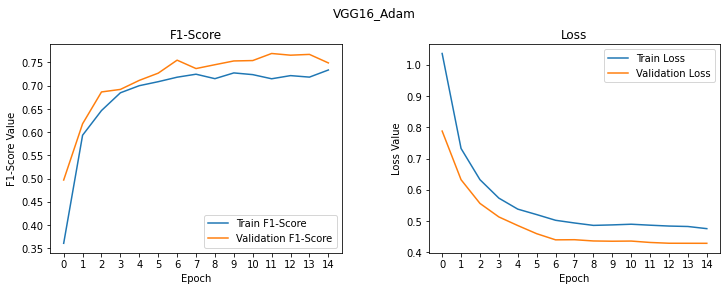

In [45]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG16_Adam', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = 15 #에폭사이즈
ax1.plot(range(epochs), flscores['train'][1:], label='Train F1-Score')
ax1.plot(range(epochs), flscores['val'][1:], label='Validation F1-Score')
ax1.set_xticks(np.arange(0, epochs))
ax1.set_ylabel('F1-Score Value')
ax1.set_xlabel('Epoch')
ax1.set_title('F1-Score')
l1 = ax1.legend(loc="best")

ax2.plot(range(epochs), losses['train'][1:], label='Train Loss')
ax2.plot(range(epochs), losses['val'][1:], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [48]:
f.savefig('vgg16adam_plt', dpi = 300)